In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/asl-fingerspelling/supplemental_metadata.csv
/kaggle/input/asl-fingerspelling/character_to_prediction_index.json
/kaggle/input/asl-fingerspelling/train.csv
/kaggle/input/asl-fingerspelling/supplemental_landmarks/371169664.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/369584223.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/1682915129.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/775880548.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/2100073719.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/1650637630.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/1471096258.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/86446671.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/897287709.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/333606065.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/2057261717.parquet
/kaggle/inpu

****Google - American Sign Language FingerSpelling Recognition****

This notebook shows how to train a model using TensorFlow on the Google-American Sign Language FingerSpelling Recognition dataset.

The objective of the model is to predict & translate American Sign Language fingerspelling from a set of video frames into text.

In this notebook we will build:
1. Installation
2. Import Libraries
3. Load Datasets
4. Quick Dataset Exploration
5. Data Visualization
6. Train a transformer model on the data
7. Convert Model to TFLite
8. Create Submission

****Installation****

In [2]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 26.8 MB/s eta 0:00:0000:0100:01


**Importing Libraries**

In [3]:
import os
import numpy as np, pandas as pd, tensorflow as tf
import shutil
import pyarrow.parquet as pq
import json
import mediapipe
import matplotlib.pyplot as plt
import random

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [4]:
from skimage.transform import resize
from mediapipe.framework.formats import landmark_pb2
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.notebook import tqdm
from matplotlib import animation, rc

In [5]:
print("TensorFlow Version " + tf.__version__)

TensorFlow Version 2.12.0


In [6]:
print("Mediapipe Version " + mediapipe.__version__)

Mediapipe Version 0.10.3


**Load Dataset**

In [7]:
df = pd.read_csv("/kaggle/input/asl-fingerspelling/train.csv")

In [8]:
print("The Shape of dataset is {}".format(df.shape))

The Shape of dataset is (67208, 5)


In [9]:
df.head(7)

,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road
5,train_landmarks/5414471.parquet,5414471,1817141095,38,www.freem.ne.jp
6,train_landmarks/5414471.parquet,5414471,1817169529,70,https://jsi.is/hukuoka


In [10]:
df.describe()

,file_id,sequence_id,participant_id
count,6.720800e+04,6.720800e+04,67208.000000
mean,1.094448e+09,1.072696e+09,119.758154
std,6.395616e+08,6.177372e+08,74.330468
min,5.414471e+06,7.109500e+04,0.000000
25%,5.277082e+08,5.376519e+08,63.000000
50%,1.099408e+09,1.074387e+09,113.000000
75%,1.662743e+09,1.605592e+09,178.000000
max,2.118949e+09,2.147465e+09,254.000000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67208 entries, 0 to 67207
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            67208 non-null  object
 1   file_id         67208 non-null  int64 
 2   sequence_id     67208 non-null  int64 
 3   participant_id  67208 non-null  int64 
 4   phrase          67208 non-null  object
dtypes: int64(3), object(2)
memory usage: 2.6+ MB


We examine the landmarks file for the first row of train.csv

In [12]:
# fetch sequence_id, file_id, phrase from first row
sequence_id, file_id, phrase = df.iloc[0][['sequence_id', 'file_id', 'phrase']]
print(f"sequence_id:{sequence_id}, file_id:{file_id}, phrase:{phrase}")

sequence_id:1816796431, file_id:5414471, phrase:3 creekhouse


Now, let us open the parquet file and fetch the data for the particular sequence_id

In [13]:
# Fetch data from parquet file
sample_sequence_df = pq.read_table(f"/kaggle/input/asl-fingerspelling/train_landmarks/{str(file_id)}.parquet",filters=[[('sequence_id', '=', sequence_id)],]).to_pandas()
print("Full sequence dataset shape is {}".format(sample_sequence_df.shape))

Full sequence dataset shape is (123, 1630)


In [14]:
sample_sequence_df.head(2)

,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1816796431,0,0.710588,0.699951,0.705657,0.691768,0.699669,0.701980,0.709724,0.610405,0.712660,...,-0.245855,-0.269148,-0.129743,-0.251501,-0.278687,-0.26653,-0.152852,-0.257519,-0.275822,-0.266876
1816796431,1,0.709525,0.697582,0.703713,0.691016,0.697576,0.700467,0.709796,0.616540,0.713729,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


****Data visualization using mediapipe APIs****

Let us visualize the hand landmarks data for the phrase 3 creek house using the hand landmarker apis of the mediapipe library.

Hand landmarks represent the key points on a human hand.

In [15]:
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
matplotlib.rcParams['savefig.pad_inches'] = 0

In [16]:
# Function create animation fro images.

matplotlib.rcParams['animation.embed_limit']=2**128
matplotlib.rcParams['savefig.pad_inches']=0
rc('animation',html='jshtml')


def create_animation(images):
    fig = plt.figure(figsize=(6,9))
    ax = plt.Axes(fig,[0.,0.,1.,1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im=ax.imshow(images[0], cmap='gray')
    plt.close(fig)
    
    
    def animate_func(i):
        im.set_array(images[i])
        return[im]
    
    return animation.FuncAnimation(fig, animate_func, frames=len(images), interval=1000/10)

In [17]:
# Extract the landmark data and convert it to an image using medipipe library.
# This function extracts the data for both hands.

mp_pose = mediapipe.solutions.pose
mp_hands = mediapipe.solutions.hands
mp_drawing = mediapipe.solutions.drawing_utils 
mp_drawing_styles = mediapipe.solutions.drawing_styles

def get_hands(seq_df):
    images = []
    all_hand_landmarks = []
    for seq_idx in range(len(seq_df)):
        x_hand = seq_df.iloc[seq_idx].filter(regex="x_right_hand.*").values
        y_hand = seq_df.iloc[seq_idx].filter(regex="y_right_hand.*").values
        z_hand = seq_df.iloc[seq_idx].filter(regex="z_right_hand.*").values

        right_hand_image = np.zeros((600, 600, 3))

        right_hand_landmarks = landmark_pb2.NormalizedLandmarkList()
        
        for x, y, z in zip(x_hand, y_hand, z_hand):
            right_hand_landmarks.landmark.add(x=x, y=y, z=z)

        mp_drawing.draw_landmarks(
                right_hand_image,
                right_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())
        
        x_hand = seq_df.iloc[seq_idx].filter(regex="x_left_hand.*").values
        y_hand = seq_df.iloc[seq_idx].filter(regex="y_left_hand.*").values
        z_hand = seq_df.iloc[seq_idx].filter(regex="z_left_hand.*").values
        
        left_hand_image = np.zeros((600, 600, 3))
        
        left_hand_landmarks = landmark_pb2.NormalizedLandmarkList()
        for x, y, z in zip(x_hand, y_hand, z_hand):
            left_hand_landmarks.landmark.add(x=x, y=y, z=z)

        mp_drawing.draw_landmarks(
                left_hand_image,
                left_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())
        
        images.append([right_hand_image.astype(np.uint8), left_hand_image.astype(np.uint8)])
        all_hand_landmarks.append([right_hand_landmarks, left_hand_landmarks])
    return images, all_hand_landmarks

In [18]:
# Get the images created using mediapipe apis
hand_images, hand_landmarks = get_hands(sample_sequence_df)
# Fetch and show the data for right hand
create_animation(np.array(hand_images)[:, 0])

****Preprocess the data****

For convenience and efficiency, we will rearrange the data so that each parquet file contains the landmark data along with the phrase it represents. This way we don't have to switch between train.csv and its parquet file.

We will save the new data in the TFRecord format. TFRecord format is a simple format for storing a sequence of binary records. Storing and loading the data using TFRecord is much more efficient and faster.

ASL-Fingerspelling mainly focusses on hand movement. So we will take hand land mark coordinates and pose coordinates for hands to train the model.

Fetch the pose landmark coordinates related to hand movement

In [19]:
# Pose coordinates for hand movement.
LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]
POSE = LPOSE + RPOSE

In [20]:
# Create x,y,z label names from coordinates


X = [f'x_right_hand_{i}' for i in range(21)] + [f'x_left_hand_{i}' for i in range(21)] + [f'x_pose_{i}' for i in POSE]
Y = [f'y_right_hand_{i}' for i in range(21)] + [f'y_left_hand_{i}' for i in range(21)] + [f'y_pose_{i}' for i in POSE]
Z = [f'z_right_hand_{i}' for i in range(21)] + [f'z_left_hand_{i}' for i in range(21)] + [f'z_pose_{i}' for i in POSE]

In [21]:
FEATURE_COLUMNS = X + Y + Z # Create feature columns from the extracted coordinates.

In [22]:
#Store ids of each coordinate labels to lists

X_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "x_" in col]
Y_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "y_" in col]
Z_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "z_" in col]

RHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "right" in col]
LHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "left" in col]
RPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col[-2:]) in RPOSE]
LPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col[-2:]) in LPOSE]

****Preprocess and write the dataset as TFRecords****

In [23]:
# Set length of frames to 128
FRAME_LEN = 128

# Create directory to store the new data
if not os.path.isdir("preprocessed"):
    os.mkdir("preprocessed")
else:
    shutil.rmtree("preprocessed")
    os.mkdir("preprocessed")

# Loop through each file_id
for file_id in tqdm(df.file_id.unique()):
    # Parquet file name
    pq_file = f"/kaggle/input/asl-fingerspelling/train_landmarks/{file_id}.parquet"
    # Filter train.csv and fetch entries only for the relevant file_id
    file_df = df.loc[df["file_id"] == file_id]
    # Fetch the parquet file
    parquet_df = pq.read_table(f"/kaggle/input/asl-fingerspelling/train_landmarks/{str(file_id)}.parquet",
                              columns=['sequence_id'] + FEATURE_COLUMNS).to_pandas()
    # File name for the updated data
    tf_file = f"preprocessed/{file_id}.tfrecord"
    parquet_numpy = parquet_df.to_numpy()
    # Initialize the pointer to write the output of 
    # each `for loop` below as a sequence into the file.
    with tf.io.TFRecordWriter(tf_file) as file_writer:
        # Loop through each sequence in file.
        for seq_id, phrase in zip(file_df.sequence_id, file_df.phrase):
            # Fetch sequence data
            frames = parquet_numpy[parquet_df.index == seq_id]
            
            # Calculate the number of NaN values in each hand landmark
            r_nonan = np.sum(np.sum(np.isnan(frames[:, RHAND_IDX]), axis = 1) == 0)
            l_nonan = np.sum(np.sum(np.isnan(frames[:, LHAND_IDX]), axis = 1) == 0)
            no_nan = max(r_nonan, l_nonan)
            
            if 2*len(phrase)<no_nan:
                features = {FEATURE_COLUMNS[i]: tf.train.Feature(
                    float_list=tf.train.FloatList(value=frames[:, i])) for i in range(len(FEATURE_COLUMNS))}
                features["phrase"] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(phrase, 'utf-8')]))
                record_bytes = tf.train.Example(features=tf.train.Features(feature=features)).SerializeToString()
                file_writer.write(record_bytes)

  0%|          | 0/68 [00:00<?, ?it/s]

****Get the saved TFRecord files into a list****

In [24]:
tf_records = df.file_id.map(lambda x: f'/kaggle/working/preprocessed/{x}.tfrecord').unique()
print(f"List of {len(tf_records)} TFRecord files.")

List of 68 TFRecord files.


In [25]:
with open ("/kaggle/input/asl-fingerspelling/character_to_prediction_index.json", "r") as f:
    char_to_num = json.load(f)

# Add pad_token, start pointer and end pointer to the dict
pad_token = 'P'
start_token = '<'
end_token = '>'
pad_token_idx = 59
start_token_idx = 60
end_token_idx = 61

char_to_num[pad_token] = pad_token_idx
char_to_num[start_token] = start_token_idx
char_to_num[end_token] = end_token_idx
num_to_char = {j:i for i,j in char_to_num.items()}

In [26]:
# Function to resize and add padding.
def resize_pad(x):
    if tf.shape(x)[0] < FRAME_LEN:
        x = tf.pad(x, ([[0, FRAME_LEN-tf.shape(x)[0]], [0, 0], [0, 0]]))
    else:
        x = tf.image.resize(x, (FRAME_LEN, tf.shape(x)[1]))
    return x

# Detect the dominant hand from the number of NaN values.
# Dominant hand will have less NaN values since it is in frame moving.
def pre_process(x):
    rhand = tf.gather(x, RHAND_IDX, axis=1)
    lhand = tf.gather(x, LHAND_IDX, axis=1)
    rpose = tf.gather(x, RPOSE_IDX, axis=1)
    lpose = tf.gather(x, LPOSE_IDX, axis=1)
    
    rnan_idx = tf.reduce_any(tf.math.is_nan(rhand), axis=1)
    lnan_idx = tf.reduce_any(tf.math.is_nan(lhand), axis=1)
    
    rnans = tf.math.count_nonzero(rnan_idx)
    lnans = tf.math.count_nonzero(lnan_idx)
    
    # For dominant hand
    if rnans > lnans:
        hand = lhand
        pose = lpose
        
        hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
        hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
        hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
        hand = tf.concat([1-hand_x, hand_y, hand_z], axis=1)
        
        pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
        pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
        pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
        pose = tf.concat([1-pose_x, pose_y, pose_z], axis=1)
    else:
        hand = rhand
        pose = rpose
    
    hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
    hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
    hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
    hand = tf.concat([hand_x[..., tf.newaxis], hand_y[..., tf.newaxis], hand_z[..., tf.newaxis]], axis=-1)
    
    mean = tf.math.reduce_mean(hand, axis=1)[:, tf.newaxis, :]
    std = tf.math.reduce_std(hand, axis=1)[:, tf.newaxis, :]
    hand = (hand - mean) / std

    pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
    pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
    pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
    pose = tf.concat([pose_x[..., tf.newaxis], pose_y[..., tf.newaxis], pose_z[..., tf.newaxis]], axis=-1)
    
    x = tf.concat([hand, pose], axis=1)
    x = resize_pad(x)
    
    x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
    x = tf.reshape(x, (FRAME_LEN, len(LHAND_IDX) + len(LPOSE_IDX)))
    return x

**Create function to parse data from TFRecord format**

In [27]:
def decode_fn(record_bytes):
    schema = {COL: tf.io.VarLenFeature(dtype=tf.float32) for COL in FEATURE_COLUMNS}
    schema["phrase"] = tf.io.FixedLenFeature([], dtype=tf.string)
    features = tf.io.parse_single_example(record_bytes, schema)
    phrase = features["phrase"]
    landmarks = ([tf.sparse.to_dense(features[COL]) for COL in FEATURE_COLUMNS])
    # Transpose to maintain the original shape of landmarks data.
    landmarks = tf.transpose(landmarks)
    
    return landmarks, phrase

**Create function to convert the data**

In [28]:
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=list(char_to_num.keys()),
        values=list(char_to_num.values()),
    ),
    default_value=tf.constant(-1),
    name="class_weight"
)

def convert_fn(landmarks, phrase):
    # Add start and end pointers to phrase.
    phrase = start_token + phrase + end_token
    phrase = tf.strings.bytes_split(phrase)
    phrase = table.lookup(phrase)
    # Vectorize and add padding.
    phrase = tf.pad(phrase, paddings=[[0, 64 - tf.shape(phrase)[0]]], mode = 'CONSTANT',
                    constant_values = pad_token_idx)
    # Apply pre_process function to the landmarks.
    return pre_process(landmarks), phrase

**Train and validation split/Create the final datasets**

In [29]:
batch_size = 64
train_len = int(0.8 * len(tf_records))

train_ds = tf.data.TFRecordDataset(tf_records[:train_len]).map(decode_fn).map(convert_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()
valid_ds = tf.data.TFRecordDataset(tf_records[train_len:]).map(decode_fn).map(convert_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()

**Define the Transformer Input Layers**

When processing landmark coordinate features for the encoder, we apply convolutional layers to downsample them and process local relationships.

We sum position embeddings and token embeddings when processing past target tokens for the decoder.

In [30]:
class TokenEmbedding(layers.Layer):
    def __init__(self, num_vocab=1000, maxlen=100, num_hid=64):
        super().__init__()
        self.emb = tf.keras.layers.Embedding(num_vocab, num_hid)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.emb(x)
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions


class LandmarkEmbedding(layers.Layer):
    def __init__(self, num_hid=64, maxlen=100):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.conv3(x)

**Encoder layer for Transformer**

In [31]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

**Decoder layer for Transformer**

In [32]:
# Customized to add `training` variable
# Reference: https://www.kaggle.com/code/shlomoron/aslfr-a-simple-transformer/notebook

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.enc_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.self_dropout = layers.Dropout(0.5)
        self.enc_dropout = layers.Dropout(0.1)
        self.ffn_dropout = layers.Dropout(0.1)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        """Masks the upper half of the dot product matrix in self attention.

        This prevents flow of information from future tokens to current token.
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [batch_size[..., tf.newaxis], tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, enc_out, target, training):
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        target_att = self.self_att(target, target, attention_mask=causal_mask)
        target_norm = self.layernorm1(target + self.self_dropout(target_att, training = training))
        enc_out = self.enc_att(target_norm, enc_out)
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out, training = training) + target_norm)
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out, training = training))
        return ffn_out_norm

**Complete the Transformer model**


This model takes landmark coordinates as inputs and predicts a sequence of characters. The target character sequence, which has been shifted to the left is provided as the input to the decoder during training. The decoder employs its own past predictions during inference to forecast the next token.

The Levenshtein Distance between sequences is used as the accuracy metric since the evaluation metric for this contest is the Normalized Total Levenshtein Distance.

In [33]:
# Customized to add edit_dist metric and training variable.
# Reference:
# https://www.kaggle.com/code/irohith/aslfr-transformer/notebook
# https://www.kaggle.com/code/shlomoron/aslfr-a-simple-transformer/notebook

class Transformer(keras.Model):
    def __init__(
        self,
        num_hid=64,
        num_head=2,
        num_feed_forward=128,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=4,
        num_layers_dec=1,
        num_classes=60,
    ):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.acc_metric = keras.metrics.Mean(name="edit_dist")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes

        self.enc_input = LandmarkEmbedding(num_hid=num_hid, maxlen=source_maxlen)
        self.dec_input = TokenEmbedding(
            num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
        )

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )

        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.classifier = layers.Dense(num_classes)

    def decode(self, enc_out, target, training):
        y = self.dec_input(target)
        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y, training)
        return y

    def call(self, inputs, training):
        source = inputs[0]
        target = inputs[1]
        x = self.encoder(source, training)
        y = self.decode(x, target, training)
        return self.classifier(y)

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch):
        """Processes one batch inside model.fit()."""
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Computes the Levenshtein distance between sequences since the evaluation
        # metric for this contest is the normalized total levenshtein distance.
        edit_dist = tf.edit_distance(tf.sparse.from_dense(target), 
                                     tf.sparse.from_dense(tf.cast(tf.argmax(preds, axis=1), tf.int32)))
        edit_dist = tf.reduce_mean(edit_dist)
        self.acc_metric.update_state(edit_dist)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result(), "edit_dist": self.acc_metric.result()}

    def test_step(self, batch):        
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        preds = self([source, dec_input])
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
        loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        # Computes the Levenshtein distance between sequences since the evaluation
        # metric for this contest is the normalized total levenshtein distance.
        edit_dist = tf.edit_distance(tf.sparse.from_dense(target), 
                                     tf.sparse.from_dense(tf.cast(tf.argmax(preds, axis=1), tf.int32)))
        edit_dist = tf.reduce_mean(edit_dist)
        self.acc_metric.update_state(edit_dist)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result(), "edit_dist": self.acc_metric.result()}

    def generate(self, source, target_start_token_idx):
        """Performs inference over one batch of inputs using greedy decoding."""
        bs = tf.shape(source)[0]
        enc = self.encoder(source, training = False)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input, training = False)
            logits = self.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = logits[:, -1][..., tf.newaxis]
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input

In [34]:
# The following callback function is used to display predictions

class DisplayOutputs(keras.callbacks.Callback):
    def __init__(
        self, batch, idx_to_token, target_start_token_idx=60, target_end_token_idx=61
    ):
        """Displays a batch of outputs after every 4 epoch

        Args:
            batch: A test batch
            idx_to_token: A List containing the vocabulary tokens corresponding to their indices
            target_start_token_idx: A start token index in the target vocabulary
            target_end_token_idx: An end token index in the target vocabulary
        """
        self.batch = batch
        self.target_start_token_idx = target_start_token_idx
        self.target_end_token_idx = target_end_token_idx
        self.idx_to_char = idx_to_token

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 4 != 0:
            return
        source = self.batch[0]
        target = self.batch[1].numpy()
        bs = tf.shape(source)[0]
        preds = self.model.generate(source, self.target_start_token_idx)
        preds = preds.numpy()
        for i in range(bs):
            target_text = "".join([self.idx_to_char[_] for _ in target[i, :]])
            prediction = ""
            for idx in preds[i, :]:
                prediction += self.idx_to_char[idx]
                if idx == self.target_end_token_idx:
                    break
            print(f"target:     {target_text.replace('-','')}")
            print(f"prediction: {prediction}\n")

**Train the Transformer mode**

In [35]:
# Transformer variables are customized from original keras tutorial to suit this dataset.
# Reference: https://www.kaggle.com/code/shlomoron/aslfr-a-simple-transformer/notebook

batch = next(iter(valid_ds))

# The vocabulary to convert predicted indices into characters
idx_to_char = list(char_to_num.keys())
display_cb = DisplayOutputs(
    batch, idx_to_char, target_start_token_idx=char_to_num['<'], target_end_token_idx=char_to_num['>']
)  # set the arguments as per vocabulary index for '<' and '>'

model = Transformer(
    num_hid=200,
    num_head=4,
    num_feed_forward=400,
    source_maxlen = FRAME_LEN,
    target_maxlen=64,
    num_layers_enc=2,
    num_layers_dec=1,
    num_classes=62
)
loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, label_smoothing=0.1,
)


optimizer = keras.optimizers.Adam(0.0001)
model.compile(optimizer=optimizer, loss=loss_fn)

history = model.fit(train_ds, validation_data=valid_ds, callbacks=[display_cb], epochs=13)

Epoch 1/13
    632/Unknown - 570s 884ms/step - loss: 0.8786 - edit_dist: 1.0910target:     <2796 west golden willow drive>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <7850 sth pererond rore>

target:     <9734719887>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <383-363-3999>

target:     <4977236992>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <498-861-2636>

target:     <reallyloud.co.uk/simaii>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <111 sororone de>

target:     <kkaicd1.pixnet.net>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <halasta-panganga-pan>

target:     <8260 john r bowdoin>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <8686 wert were>

target:     <56 paper birch drive>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <461-383-383>

target:     <gandchudaihardcor.html>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <303-393-0010>

target:     <2708 west 77th>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

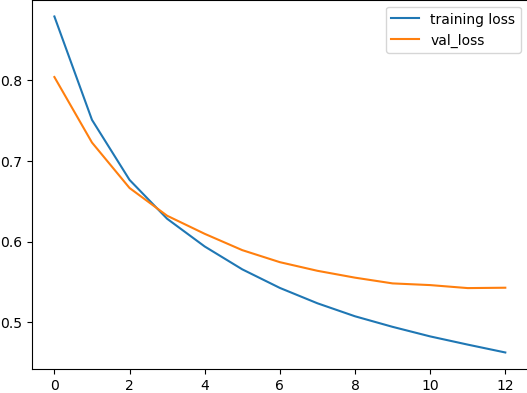

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'val_loss'])

In [37]:
 class TFLiteModel(tf.Module):
    def __init__(self, model):
        super(TFLiteModel, self).__init__()
        self.target_start_token_idx = start_token_idx
        self.target_end_token_idx = end_token_idx
        # Load the feature generation and main models
        self.model = model
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, len(FEATURE_COLUMNS)], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs, training=False):
        # Preprocess Data
        x = tf.cast(inputs, tf.float32)
        x = x[None]
        x = tf.cond(tf.shape(x)[1] == 0, lambda: tf.zeros((1, 1, len(FEATURE_COLUMNS))), lambda: tf.identity(x))
        x = x[0]
        x = pre_process(x)
        x = x[None]
        x = self.model.generate(x, self.target_start_token_idx)
        x = x[0]
        idx = tf.argmax(tf.cast(tf.equal(x, self.target_end_token_idx), tf.int32))
        idx = tf.where(tf.math.less(idx, 1), tf.constant(2, dtype=tf.int64), idx)
        x = x[1:idx]
        x = tf.one_hot(x, 59)
        return {'outputs': x}
    
tflitemodel_base = TFLiteModel(model)

In [38]:
model.save_weights("model.h8")

In [39]:
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflitemodel_base)
keras_model_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]#, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = keras_model_converter.convert()
with open('/kaggle/working/model.tflite', 'wb') as f:
    f.write(tflite_model)
    
infargs = {"selected_columns" : FEATURE_COLUMNS}

with open('inference_args.json', "w") as json_file:
    json.dump(infargs, json_file)

In [40]:
!zip submission.zip  './model.tflite' './inference_args.json'

  adding: model.tflite (deflated 18%)
  adding: inference_args.json (deflated 85%)
